### Stocks Analysis
What factors make for a successful stock investment? This code is an attempt to answer this simple question. I find the best performing stocks in a period and see if I can find clues in their fundamentals that make them successful stocks. 


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import random
import yfinance as yf
from datetime import datetime, timedelta
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
import sys
import os

sys.path.append("../")
from edgar_utils import ticker_to_cik, get_companywide_concepts, get_financial_item
from adamodaran_utils import get_industry_list, get_industry_df

from pprint import pprint

In [2]:
# Set up the environment
yf.set_tz_cache_location("../cache/yfinance")
pd.set_option('display.width', 1000)
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
   pass

session = CachedLimiterSession(
   limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds
   bucket_class=MemoryQueueBucket,
   backend=SQLiteCache("../cache/yfinance/yfinance.cache"),
)
session.headers['User-agent'] = 'my-program/1.0'

In [3]:
# get_historical_returns ---------------------------------------------------------------------------------------------------------------
#   Returns the total anualized returns in percentage for a given ticker and no. of years. The no. of years defaults to 10
# --------------------------------------------------------------------------------------------------------------------------------------
def get_historical_returns(ticker, interval = "3mo", no_of_years = 10):
    try:
        price_df = yf.download(ticker, period="1d", session=session,progress=False)
        if price_df.empty:
            return(None)
    except:
        return(None)
    end_date = price_df.index[0]
    start_date = end_date - pd.DateOffset(years=no_of_years+1)  # We need 11 years of data to be able to calculate 10 years of returns

    try:
        data = yf.download(ticker, start=start_date, end=end_date, interval=interval, progress=False)
        if data.empty:
            return(None)
    except:
        return(None)
    price_data = data['Adj Close'].resample("YE").last()
    total_annual_return = price_data.pct_change()*100
    total_annual_return.drop(index=total_annual_return.index[0], inplace=True)
    return(total_annual_return)

In [4]:
# get_historical_adj_prices ---------------------------------------------------------------------------------------------------------------
#   Returns the adjusted stock prices. The no. of years defaults to 10
# --------------------------------------------------------------------------------------------------------------------------------------
def get_investment_growth(ticker, no_of_years = 10):
    try:
        price_df = yf.download(ticker, period="1d", session=session,progress=False)
        if price_df.empty:
            return(None)
    except:
        return(None)
    end_date = price_df.index[0]
    start_date = end_date - pd.DateOffset(years=no_of_years+1)  # We need 11 years of data to be able to calculate 10 years of returns

    try:
        data = yf.download(ticker, start=start_date, end=end_date, interval="1wk", progress=False)
        if data.empty:
            return(None)
    except:
        return(None)
    price_data = data['Adj Close'].resample("W").last()
    price_data = 100*price_data/price_data.iloc[0]
    price_data.rename(ticker, inplace=True)
    return(price_data)


### Calculating total return
We want to calculate the stock return taking into account dividends paid. One way to do this is to assume that the dividends were reinvested into the stock. Suppose a stock at the beginning of the year was $24 and became $28 at the end of the year, but a dividend of $0.08 was paid in-between right after a day when the closing price was $24.95, then the total return is:

$$
\begin{align*}
r   &= \left( \dfrac{28 + 0.08\times\dfrac{28}{24.95}}{24} \right) - 1\\
    &= \dfrac{28}{24} \left( 1+\dfrac{0.08}{24.95} \right) - 1
\end{align*}
$$

[Yahoo does adjustments for splits and dividends](https://help.yahoo.com/kb/SLN28256.html?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAFje9jIInmwS1WuWOB8yCrrcQlQRzvnHwPb5JwJpM1bB1pkpLUJKuEJznLZB5S-h_4mj4LuRqTGEM5tAqHESlWTLoXyOQXkGyDDM5kTt3mPBN-Na57XBw5hd6yahp3J1C1nfuHQgpt1y4TuuKKuCdWr6DQWRUPxiJWpAuQKcPCmU) and provides data called "Adj Close" price. It is quite easy to understand how they adjust for splits. But the way they adjust for dividends is a little different. When a dividend is paid, they calculate how much of the stock price (based on prev day closing price) that dividend represented. Say it is 0.2%. They take away 0.2% from all the prices preceding that dividend payment. What they are effectively saying is that, the original stock prices before the dividend contained two parts - one that is 99.8% of it that remains in the stock and a 0.2% part that eventually got paid out as a dividend. In other words, their return, if calculated using their "Adj Close" would be[^1]:

$$
\hat{r} = \left( \dfrac{28}{24\times\left(1-\dfrac{0.08}{24.95}\right)} \right) - 1
$$

The two methods aren't very different if the dividend amount is small. In this case, it represents 0.32%. You can see this by multplying the numerator and denominator in my return calculation by $\left(1-\frac{0.08}{24.95}\right)$.

$$
\begin{align*}
r   &= \dfrac{28}{24} \left( 1+\dfrac{0.08}{24.95} \right) - 1 \\
    &= \dfrac{28}{24} \left(\dfrac{1-\dfrac{0.08}{24.95}}{1-\dfrac{0.08}{24.95}}\right) \left( 1+\dfrac{0.08}{24.95} \right) - 1 \\
    &= \left( \dfrac{28}{24\times\left(1-\dfrac{0.08}{24.95}\right)} \right) \left(1^2-\left(\dfrac{0.08}{24.95} \right)^2 \right) - 1 \\
    &= \hat{r}(1-0.00001024) \\
    &\approx \hat{r}
\end{align*}
$$

For our purposes, using "Adj. Close" is sufficient. 

[^1]: Note that there is a major typo in the Yahoo page: They used $24.95 as the denominator instead of $24.95. But if you expand the "Multipliers" section, it is quite clear they meant to use $24.95. Also, they don't use a 1 year starting price of $24 that I have used. I thought using a 1 year return would be intuitive.

In [5]:
COMPARISON_YEARS = 10

In [ ]:

# Randomly select an industry and get a list of companies
ind_list = get_industry_list()
ind_list_sample = random.sample(list(ind_list), 1)
print("Industry(ies): {}".format(ind_list_sample))
companies_list = get_industry_df(ind_list_sample).set_index('ticker')

# Find all the companies that beat S&P500 7 or more years in the last 10 years
benchmark_total_annual_return = get_historical_returns("SPY", no_of_years=COMPARISON_YEARS)
shortlisted_tickers = []
for ticker in companies_list.index:
    print(ticker)
    total_annual_return = get_historical_returns(ticker, no_of_years=COMPARISON_YEARS)
    if total_annual_return is None:
        continue
    diff_return = total_annual_return - benchmark_total_annual_return
    companies_list.loc[ticker, 'alpha'] = ((1 + total_annual_return / 100).prod() - (1 + benchmark_total_annual_return / 100).prod())*100
    positive_returns = diff_return[diff_return>0]
    if positive_returns.count() >= (COMPARISON_YEARS*0.7):    # Arbitrary criterion for declearing a stock is a good stock
        shortlisted_tickers.append(ticker)
print("Shortlist: {}".format(shortlisted_tickers))

In [6]:
shortlisted_companies = companies_list[companies_list.index.isin(shortlisted_tickers)]
shortlisted_companies
if os.path.isfile("shortlisted_companies.csv"):
    shortlisted_companies.to_csv("shortlisted_companies.csv", mode="a", header=False)
else:
    shortlisted_companies.to_csv("shortlisted_companies.csv", header=True)

4.121137442496801
3.5312037232917293
                   TJX   benchmark
Date                              
2014-01-26  100.000000  100.000000
2014-02-02   99.324665   99.603104
2014-02-09  102.909109  100.441591
2014-02-16  103.532479  102.867704
2014-02-23  104.289829  102.794999


Text(0.5, 1.0, 'Growth of $100')

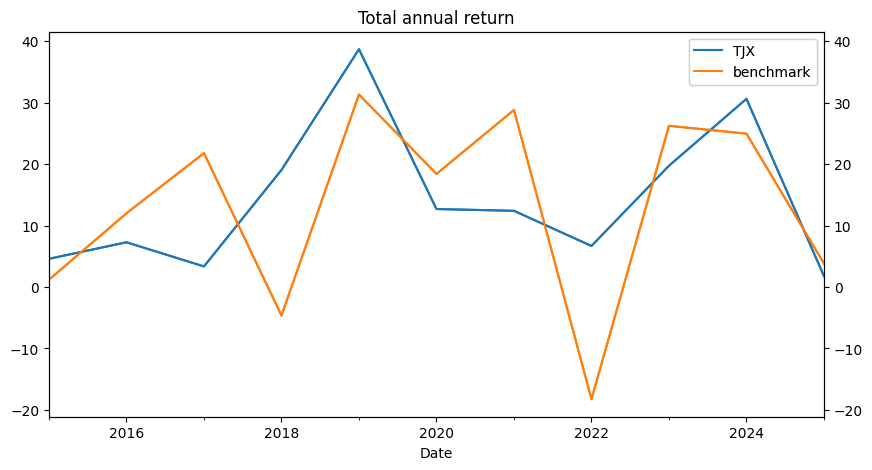

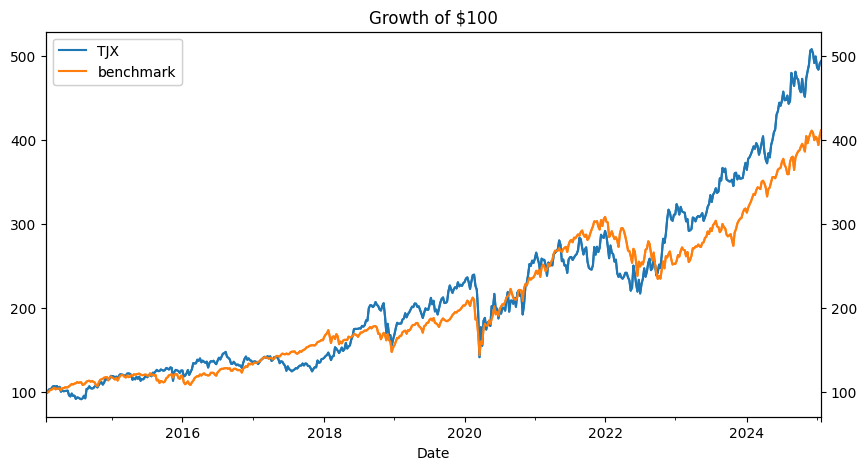

In [6]:
# Research individual companies. The following code is mainly for debugging
import matplotlib.pyplot as plt

ticker = "TJX"

total_annual_return = get_historical_returns(ticker, no_of_years=COMPARISON_YEARS)

benchmark_total_annual_return = get_historical_returns("SPY", no_of_years=COMPARISON_YEARS)

diff_return = total_annual_return - benchmark_total_annual_return
total_return = ((1 + total_annual_return / 100).prod() - 1)*100
pprint((1 + total_annual_return / 100).prod())
pprint((1 + benchmark_total_annual_return / 100).prod())

total_benchmark_return = ((1 + benchmark_total_annual_return / 100).prod() - 1)*100
alpha = ((1 + total_annual_return / 100).prod() - (1 + benchmark_total_annual_return / 100).prod())*100
positive_returns = diff_return[diff_return>0]

# Display
tempdf = pd.DataFrame(index=total_annual_return.index)  # Just for a better display
tempdf[ticker] = total_annual_return
tempdf['benchmark'] = benchmark_total_annual_return
tempdf['diff'] = diff_return
# pprint(tempdf)
# print("Total {} return: {}".format(ticker, total_return))
# print("Alpha: {}".format(alpha))

fig,ax = plt.subplots(1,1,figsize=(10,5))
tempdf.plot(y=[ticker, 'benchmark'], ax=ax)

ax2 = ax.twinx()
tempdf.plot(y=[ticker, 'benchmark'], ax=ax2)
plt.title("Total annual return")

ticker_adj_prices = get_investment_growth(ticker=ticker)
benchmark_adj_prices = get_investment_growth(ticker="SPY")
pricesdf = pd.DataFrame(index=ticker_adj_prices.index)  # Just for a better display
pricesdf[ticker] = ticker_adj_prices
pricesdf['benchmark'] = benchmark_adj_prices
pprint(pricesdf.head())

fign,axn = plt.subplots(1,1,figsize=(10,5))
pricesdf.plot(ax=axn)
axn2 = axn.twinx()
pricesdf.plot(ax=axn2)
plt.title("Growth of $100")
